<a href="https://colab.research.google.com/github/gabsrcha/Gabrielly_PIBIC_Lung.Node.Segmentation/blob/colab/Gabs_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch import randint
!pip install torchmetrics
from torchmetrics.classification import Dice
from sklearn.metrics import accuracy_score
import torchmetrics

In [2]:
pip freeze > requirements.txt

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [4]:
transform = T.ToTensor()

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/train/images/"))
train_mask = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/train/mask/"))
train_imgs = np.array(train_images)
train_masks = np.array(train_mask)


valid_images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/valid/images/"))
valid_mask = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/valid/mask/"))
val_imgs = np.array(valid_images)
val_masks = np.array(valid_mask)

In [7]:
def custom_collate(data):
#   data = [d for d in data if d[1]["boxes"].shape[0] > 0]
  return data

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.005)

In [10]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/Gabs_lung/train/images/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/Gabs_lung/train/mask/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        #print(np.where(mask > np.min(mask)))
        for i in range(num_objs):
            #masks[i][mask == i+1] = True
            masks[i][mask > 0] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        #print(boxes)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)


class CustDatVal(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/drive/MyDrive/Gabs_lung/valid/images/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/drive/MyDrive/Gabs_lung/valid/mask/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            #masks[i][mask == i+1] = True
            masks[i][mask > 0] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [11]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks),
                                 batch_size = 100,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(CustDatVal(val_imgs , val_masks) ,
                                 batch_size = 57,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)


In [12]:
#train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks))
#val_dl = torch.utils.data.DataLoader(CustDatVal(val_imgs , val_masks))

all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(350):
    #print(epoch)
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        if len(dt) <= 1:
            print("++++",i)
            continue
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.2018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.7048, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)}
0    5.700175762176514    3.32804012298584
1    4.4897661209106445    2.4457058906555176
2    4.417466402053833    2.1376824378967285
3    5.798813343048096    2.550645112991333
4    4.9747772216796875    2.1764869689941406
5    4.357485294342041    2.1030704975128174
6    4.344557762145996    2.027541399002075
7    3.9966219663619995    2.1755242347717285
8    3.962887763977051    1.9413254261016846
9    3.4793224334716797    1.7789021730422974
10    3.4858133792877197    1.766650915145874
11    3.6433149576187134    1.696942925453186
12    3.647750258

In [13]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Gabs_lung/modelgabs3.pt')

In [14]:
images = sorted(os.listdir("/content/drive/MyDrive/Gabs_lung/general/images/"))

In [15]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Gabs_lung/modelgabs3.pt'))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

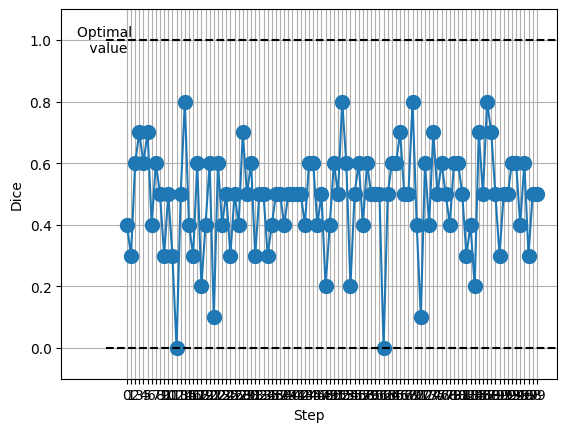

In [16]:
# Example plotting multiple values
metric = Dice()
values = [ ]
for _ in range(100):
  values.append(metric(randint(2,(10,)), randint(2,(10,))))
fig_, ax_ = metric.plot(values)

In [27]:
from torchvision.models.detection import image_list
l=0

model.eval()

#while (l<61):
#for l in range(1,len(images)):
f = plt.figure()

for l in images:
    print(l)
    img = Image.open("/content/drive/MyDrive/Gabs_lung/general/images/"+str(l))
    mask = Image.open("/content/drive/MyDrive/Gabs_lung/general/mask/"+str(l))
    transform = T.ToTensor()
    ig = transform(img)
    with torch.no_grad():
        pred = model([ig.to(device)])
        try:
          # Converte as máscaras para arrays numpy
          pred_mask = (pred[0]["masks"][0].cpu().numpy() > 0).astype(int)
          true_mask = (np.array(mask) > 0).astype(int)

          # Calcula o valor Dice
          dice_metric = torchmetrics.classification.Dice()
          dice_value = dice_metric(torch.from_numpy(pred_mask), torch.from_numpy(true_mask))
          print(f"Valor Dice: {dice_value.item()}")

          # Calcula a acurácia
          accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
          print(f"Acurácia: {accuracy}")
          plt.imshow((pred[0]["masks"][0].cpu().detach().numpy()*255).astype("uint8").squeeze(), cmap='gray')

          # # Subplot para a máscara
          # plt.subplot(1, 3, 1)
          # plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze(), cmap='gray')
          # plt.axis('off')
          # plt.title("Máscara")

          # # Subplot para a imagem original
          # plt.subplot(1, 3, 2)
          # plt.imshow(mask)
          # plt.axis('off')
          # plt.title("Máscara Original")

          # # Subplot para a imagem original
          # plt.subplot(1, 3, 3)
          # plt.imshow(img)
          # plt.axis('off')
          # plt.title("Imagem Original")

          plt.savefig("/content/drive/MyDrive/Gabs_lung/test4/"+str(l), format='png', bbox_inches='tight',pad_inches=0)
          plt.clf()
        except IndexError:
            pass


1.png
Valor Dice: 0.9977989196777344
Acurácia: 0.9977989196777344
10.png
Valor Dice: 0.9992752075195312
Acurácia: 0.9992752075195312
101.png
102.png
Valor Dice: 0.9977493286132812
Acurácia: 0.9977493286132812
103.png
Valor Dice: 0.998992919921875
Acurácia: 0.998992919921875
104.png
Valor Dice: 0.9974632263183594
Acurácia: 0.9974632263183594
105.png
Valor Dice: 0.9980964660644531
Acurácia: 0.9980964660644531
106.png
Valor Dice: 0.9972457885742188
Acurácia: 0.9972457885742188
107.png
Valor Dice: 0.9973297119140625
Acurácia: 0.9973297119140625
108.png
Valor Dice: 0.9966926574707031
Acurácia: 0.9966926574707031
109.png
Valor Dice: 0.9977188110351562
Acurácia: 0.9977188110351562
11.png
Valor Dice: 0.9991416931152344
Acurácia: 0.9991416931152344
110.png
Valor Dice: 0.9980239868164062
Acurácia: 0.9980239868164062
111.png
Valor Dice: 0.9978828430175781
Acurácia: 0.9978828430175781
112.png
Valor Dice: 0.99884033203125
Acurácia: 0.99884033203125
113.png
Valor Dice: 0.9974517822265625
Acurácia: 0

<Figure size 640x480 with 0 Axes>

In [23]:
from sklearn.metrics import accuracy_score
import torchmetrics
import numpy as np

# ...

# Após a geração das máscaras pelo modelo
with torch.no_grad():
    pred = model([ig.to(device)])
    try:
        # Converte as máscaras para arrays numpy
        pred_mask = (pred[0]["masks"][0].cpu().numpy() > 0).astype(int)
        true_mask = (np.array(mask) > 0).astype(int)

        # Calcula o valor Dice
        dice_metric = torchmetrics.classification.Dice()
        dice_value = dice_metric(torch.from_numpy(pred_mask), torch.from_numpy(true_mask))
        print(f"Valor Dice: {dice_value.item()}")

        # Calcula a acurácia
        accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        print(f"Acurácia: {accuracy}")

        # Continua com a geração das imagens e outros processamentos
    except IndexError:
        pass


Valor Dice: 0.9991035461425781
Acurácia: 0.9991035461425781
